In [1]:
#Udai Nagpal, 
# -----------Part 5(iv)------------
import numpy as np
import math
from numpy import linalg as LA

#Element by element sigmoid of column vector
def sigmoid(x):
    output = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
        output[i,0] = 1.0/(1.0+math.exp(-x[i,0]))
    return output

#Scalar sigmoid
def sigmoid_deriv_scalar(x):
    sig_x = 1.0/(1.0+math.exp(-x))
    return sig_x * (1-sig_x)

def sigmoid_scalar(x):
    return 1.0/(1.0+math.exp(-x))

#Element by element sigmoid derivative of column vector
def sigmoid_deriv(x):
    output = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        temp_arr = np.zeros((1,1))
        temp_arr[0][0] = x[i,0]
        output[i,0] = sigmoid(temp_arr) * (1 - sigmoid(temp_arr))
    return output
y = np.array([[1],[2],[-1],[-3]])
print(sigmoid(y))
print(sigmoid_deriv(y))

[[0.73105858]
 [0.88079708]
 [0.26894142]
 [0.04742587]]
[[0.19661193]
 [0.10499359]
 [0.19661193]
 [0.04517666]]


In [2]:
def stochastic_gradient_descent (input_data, output_data, inter_layer_sizes, convergence_cutoff=0.00001, max_iterations=50, minibatch_size=25, learning_rate=0.2):
    layer_sizes = [len(input_data[0])] + inter_layer_sizes + [len(output_data[0])]
    num_layers = len(layer_sizes)
    #Random Initialization
    W = [np.random.uniform(low=-2.0, high=2.0, size=(layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    dW = [[np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)] for j in range(minibatch_size)]
    b = [np.random.uniform(low=-2.0, high=2.0, size=(layer_sizes[i+1],)) for i in range(num_layers-1)]
    db = [[np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)] for j in range(minibatch_size)]
    abs_adjustments_W = [100*np.ones((layer_sizes[i],layer_sizes[i+1])) for i in range(num_layers-1)]
    abs_adjustments_b = [100*np.ones((layer_sizes[i+1],)) for i in range(len(layer_sizes)-1)]
    #print('W:' + str(W))
    #print('b:' + str(b))
    elapsed_iterations = 0
    max_adjustment_W, max_adjustment_b = 100, 100
    while(elapsed_iterations<max_iterations and max_adjustment_W>=convergence_cutoff and max_adjustment_b>=convergence_cutoff):
        stochastic_sample = np.random.choice(a=len(output_data),size=minibatch_size, replace=False)
        sample_inputs = [input_data[i] for i in stochastic_sample]
        sample_outputs = [output_data[i] for i in stochastic_sample]
        dW_sum = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        db_sum = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
        sample_predictions = []
        running_cost = 0
        for sample in range(len(sample_outputs)):
            x = sample_inputs[sample]
            y = sample_outputs[sample]
            #print('sample input: ' + str(x))
            #print('sample output: ' + str(y))
            saved_forward_pass = [x]
            layer_input = x
            #Forward Pass
            for layer in range(num_layers-1):
                layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
                out_dim = layer_output.shape[0]
                layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
                layer_input = np.hstack(layer_input)
                saved_forward_pass.append(layer_input)
            sample_prediction = np.array(saved_forward_pass[-1:])
            running_cost += LA.norm(np.subtract(sample_prediction, np.array(y)))**2.0
            #BACKPROPAGATION
            deltas = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
            for output_component in range(len(deltas[num_layers-2])):
                deltas[num_layers-2][output_component] = -1.0 * (y[output_component]-saved_forward_pass[-1][output_component])*saved_forward_pass[-1][output_component]*(1-saved_forward_pass[-1][output_component])
            #Backpropagating Deltas
            for layer in range(num_layers-3, -1, -1):
                for neuron_ind in range(len(saved_forward_pass[layer+1])):
                    sigmoid_val = saved_forward_pass[layer+1][neuron_ind]
                    partial_sigmoid = (sigmoid_val) * (1 - sigmoid_val)
                    corr_weights = np.array(W[layer+1][neuron_ind,:])
                    corr_deltas = np.array(deltas[layer+1])
                    deltas[layer][neuron_ind] = partial_sigmoid * np.dot(corr_weights, corr_deltas)
            #Computing gradient of cost function w.r.t. W and b
            for layer in range(num_layers-1):
                for j in range(len(saved_forward_pass[layer+1])):
                    for i in range(len(saved_forward_pass[layer])):
                        dW[sample][layer][i,j] = deltas[layer][j] * saved_forward_pass[layer][i]
                    db[sample][layer][j] = deltas[layer][j]
            for i in range(len(dW_sum)):
                dW_sum[i] = np.add(dW_sum[i], dW[sample][i])
            #print(dW[sample])
            #dW_sum = np.add(dW_sum, dW[sample])
            db_sum = np.add(db_sum,db[sample])
            #print('deltas: ' + str(deltas))
            #print('dW: ' + str(dW))
            #print('db: ' + str(db))
        print("Cost Function: " + str(running_cost/(2.0*minibatch_size)))
        #print('dW sum: ' + str(dW_sum))
        db_avg = db_sum / minibatch_size
        dW_avg = [dWi/minibatch_size for dWi in dW_sum]
        #Updating Weight Parameters and Checking for Convergence
        max_adjustment_W = 0
        max_adjustment_b = 0
        for layer in range(num_layers-1):
            W[layer] = W[layer] - learning_rate * dW_avg[layer]
            b[layer] = b[layer] - learning_rate * db_avg[layer]
            adj_W = np.absolute(learning_rate * dW_avg[layer])
            adj_b = np.absolute(learning_rate * db_avg[layer])
            if (np.amax(adj_W) > max_adjustment_W):
                max_adjustment_W = np.amax(adj_W)
            if (np.amax(adj_b) > max_adjustment_b):
                max_adjustment_b = np.amax(adj_b)
        #print('Updated W: ' + str(W))
        #print('Updated b: ' + str(b))
        elapsed_iterations += 1
        #print(elapsed_iterations)
    #Final Output Predictions from Trained Model  
    final_pred_outputs = []
    for input_point in input_data:
        forward_pass = [input_point]
        layer_input = input_point
        for layer in range(num_layers-1):
            layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
            #print(layer_output)
            out_dim = layer_output.shape[0]
            layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
            layer_input = np.hstack(layer_input)
            forward_pass.append(layer_input)
        #print(forward_pass)
        final_pred_outputs.append(forward_pass[-1:])
    final_pred_outputs = [output.tolist() for out_list in final_pred_outputs for output in out_list]
    print("Final W: " + str(W))
    print("Final b: " + str(b))
    #print("Actual Outputs: " + str(output_data))
    #print("Predicted Outputs: " + str(final_pred_outputs))
    print("Total Elapsed Iterations: " + str(elapsed_iterations))

In [3]:
#TEST OF STOCHASTIC GRADIENT DESCENT: COST FUNCTION IS INDEED MINIMIZED
my_input = [i.tolist() for i in np.random.uniform(size=(100,2))]
#print(my_input)
my_output = []
for j in range(len(my_input)):
    my_output.append([sigmoid_scalar(1*my_input[j][0] +2*my_input[j][1] - 1), sigmoid_scalar(1.2*my_input[j][0] +1.7*my_input[j][1] - 1.3)])
my_output = np.array(my_output)
#print(my_output)
stochastic_gradient_descent(my_input, my_output, [2,2])

Cost Function: 0.28454544739563964
Cost Function: 0.2856261082015713
Cost Function: 0.3178429652039684
Cost Function: 0.3036175961890476
Cost Function: 0.2749078839513117
Cost Function: 0.2710682022622916
Cost Function: 0.31277488285333843
Cost Function: 0.30168520620166495
Cost Function: 0.2954792768186227
Cost Function: 0.31625156987164726
Cost Function: 0.29286242276001145
Cost Function: 0.2657570986610482
Cost Function: 0.288808566224459
Cost Function: 0.26623556978465784
Cost Function: 0.31455806726570634
Cost Function: 0.29039881590210087
Cost Function: 0.2775384491851051
Cost Function: 0.2850072427284938
Cost Function: 0.26949494039913374
Cost Function: 0.3130286869238451
Cost Function: 0.36511598474310597
Cost Function: 0.32098872180993077
Cost Function: 0.26623394114218385
Cost Function: 0.298770303870257
Cost Function: 0.27373331801929973
Cost Function: 0.258972106242049
Cost Function: 0.2552160701022693
Cost Function: 0.2966324311970218
Cost Function: 0.279332528892715
Cost 

In [4]:
def adam (input_data, output_data, inter_layer_sizes, convergence_cutoff=0.000001, max_iterations=3000, minibatch_size=100, learning_rate=0.0015):
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 10**(-8.0)
    layer_sizes = [len(input_data[0])] + inter_layer_sizes + [len(output_data[0])]
    num_layers = len(layer_sizes)
    #Random Initialization
    W = [np.random.uniform(low=-1.0, high=1.0, size=(layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    dW = [[np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)] for j in range(minibatch_size)]
    b = [np.random.uniform(low=-1.0, high=1.0, size=(layer_sizes[i+1],)) for i in range(num_layers-1)]
    db = [[np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)] for j in range(minibatch_size)]
    m = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    v = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    m_b = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
    v_b = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
    abs_adjustments_W = [100*np.ones((layer_sizes[i],layer_sizes[i+1])) for i in range(num_layers-1)]
    abs_adjustments_b = [100*np.ones((layer_sizes[i+1],)) for i in range(len(layer_sizes)-1)]
    #print('W:' + str(W))
    #print('b:' + str(b))
    elapsed_iterations = 0
    max_adjustment_W, max_adjustment_b = 100, 100
    while(elapsed_iterations<max_iterations and max_adjustment_W>=convergence_cutoff and max_adjustment_b>=convergence_cutoff):
        stochastic_sample = np.random.choice(a=len(output_data),size=minibatch_size, replace=False)
        sample_inputs = [input_data[i] for i in stochastic_sample]
        sample_outputs = [output_data[i] for i in stochastic_sample]
        dW_sum = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        db_sum = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
        sample_predictions = []
        running_cost = 0
        for sample in range(len(sample_outputs)):
            x = sample_inputs[sample]
            y = sample_outputs[sample]
            #print('sample input: ' + str(x))
            #print('sample output: ' + str(y))
            saved_forward_pass = [x]
            layer_input = x
            #Forward Pass
            for layer in range(num_layers-1):
                layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
                out_dim = layer_output.shape[0]
                layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
                layer_input = np.hstack(layer_input)
                saved_forward_pass.append(layer_input)
            sample_prediction = np.array(saved_forward_pass[-1:])
            running_cost += LA.norm(np.subtract(sample_prediction, np.array(y)))**2.0
            #BACKPROPAGATION
            deltas = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
            for output_component in range(len(deltas[num_layers-2])):
                deltas[num_layers-2][output_component] = -1.0 * (y[output_component]-saved_forward_pass[-1][output_component])*saved_forward_pass[-1][output_component]*(1-saved_forward_pass[-1][output_component])
            #Backpropagating Deltas
            for layer in range(num_layers-3, -1, -1):
                for neuron_ind in range(len(saved_forward_pass[layer+1])):
                    sigmoid_val = saved_forward_pass[layer+1][neuron_ind]
                    partial_sigmoid = (sigmoid_val) * (1 - sigmoid_val)
                    corr_weights = np.array(W[layer+1][neuron_ind,:])
                    corr_deltas = np.array(deltas[layer+1])
                    deltas[layer][neuron_ind] = partial_sigmoid * np.dot(corr_weights, corr_deltas)
            #Computing gradient of cost function w.r.t. W and b
            for layer in range(num_layers-1):
                for j in range(len(saved_forward_pass[layer+1])):
                    for i in range(len(saved_forward_pass[layer])):
                        dW[sample][layer][i,j] = deltas[layer][j] * saved_forward_pass[layer][i]
                    db[sample][layer][j] = deltas[layer][j]
            for i in range(len(dW_sum)):
                dW_sum[i] = np.add(dW_sum[i], dW[sample][i])
            #print(dW[sample])
            #dW_sum = np.add(dW_sum, dW[sample])
            db_sum = np.add(db_sum,db[sample])
            #print('deltas: ' + str(deltas))
            #print('dW: ' + str(dW))
            #print('db: ' + str(db))
        print("Cost Function: " + str(running_cost/(2.0*minibatch_size)))
        #print('dW sum: ' + str(dW_sum))
        db_avg = db_sum / minibatch_size
        dW_avg = [dWi/minibatch_size for dWi in dW_sum]
        #Updating Weight Parameters and Checking for Convergence
        max_adjustment_W = 0
        max_adjustment_b = 0
        for layer in range(num_layers-1):
            m[layer] = beta_1 * m[layer] + (1-beta_1)*dW_avg[layer]
            v[layer] = beta_2 * v[layer] + (1-beta_2)*np.square(dW_avg[layer])
            eps_matrix = epsilon * np.ones((np.shape(dW_avg[layer])[0], np.shape(dW_avg[layer])[1]))
            W[layer] = W[layer] - learning_rate * np.divide(m[layer], np.add(np.sqrt(v[layer]), eps_matrix))
            m_b[layer] = beta_1 * m_b[layer] + (1-beta_1)*db_avg[layer]
            v_b[layer] = beta_2 * v_b[layer] + (1-beta_2)*np.square(db_avg[layer])
            eps_matrix_b = epsilon * np.ones((np.shape(db_avg[layer])[0]))
            b[layer] = b[layer] - learning_rate * np.divide(m_b[layer], np.add(np.sqrt(v_b[layer]), eps_matrix_b))
            #b[layer] = b[layer] - learning_rate * db_avg[layer]
            adj_W = np.absolute(learning_rate * np.divide(m[layer], np.add(np.sqrt(v[layer]), eps_matrix)))
            adj_b = np.absolute(learning_rate * np.divide(m_b[layer], np.add(np.sqrt(v_b[layer]), eps_matrix_b)))
            if (np.amax(adj_W) > max_adjustment_W):
                max_adjustment_W = np.amax(adj_W)
            if (np.amax(adj_b) > max_adjustment_b):
                max_adjustment_b = np.amax(adj_b)
        #print('Updated W: ' + str(W))
        #print('Updated b: ' + str(b))
        elapsed_iterations += 1
        #print(elapsed_iterations)
    #Final Output Predictions from Trained Model  
    final_pred_outputs = []
    for input_point in input_data:
        forward_pass = [input_point]
        layer_input = input_point
        for layer in range(num_layers-1):
            layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
            #print(layer_output)
            out_dim = layer_output.shape[0]
            layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
            layer_input = np.hstack(layer_input)
            forward_pass.append(layer_input)
        #print(forward_pass)
        final_pred_outputs.append(forward_pass[-1:])
    final_pred_outputs = [output.tolist() for out_list in final_pred_outputs for output in out_list]
    print("Final W: " + str(W))
    print("Final b: " + str(b))
    #print("Actual Outputs: " + str(output_data))
    #print("Predicted Outputs: " + str(final_pred_outputs))
    print("Total Elapsed Iterations: " + str(elapsed_iterations))
    return final_pred_outputs

#Testing adam
adam(input_data=my_input, output_data = my_output, inter_layer_sizes=[2,2],max_iterations=50, minibatch_size=15)

Cost Function: 0.12079137737129993
Cost Function: 0.08801134089221149
Cost Function: 0.14806476427318244
Cost Function: 0.1195410893097882
Cost Function: 0.07464137697828514
Cost Function: 0.12343349128897493
Cost Function: 0.09081113629037786
Cost Function: 0.07245572382449297
Cost Function: 0.11365677037386891
Cost Function: 0.1346215639712975
Cost Function: 0.08793710163611605
Cost Function: 0.08617097574904017
Cost Function: 0.11309850553825203
Cost Function: 0.1034418529707422
Cost Function: 0.1001831026909947
Cost Function: 0.0894016835012251
Cost Function: 0.08182453365712118
Cost Function: 0.08403425870126079
Cost Function: 0.0900262561452875
Cost Function: 0.08006794418013004
Cost Function: 0.09797876172547378
Cost Function: 0.0534908642104338
Cost Function: 0.045465975817086245
Cost Function: 0.06636516170316156
Cost Function: 0.08224241487958675
Cost Function: 0.08316479468789449
Cost Function: 0.08372927443364388
Cost Function: 0.09537645139698629
Cost Function: 0.088013584

[[0.46862209465812177, 0.4392888302343429],
 [0.47193173004151295, 0.4360583715487365],
 [0.4496207533712166, 0.45794116010262464],
 [0.4659276874006687, 0.4419581858165651],
 [0.4690947016510776, 0.43880387942205157],
 [0.46119529876088355, 0.4464474932388842],
 [0.47335540569356155, 0.4346944472299449],
 [0.4665560690993997, 0.4413207951056514],
 [0.44697197532541644, 0.4606043269024722],
 [0.4625595108059079, 0.4452639923827097],
 [0.46620649282039855, 0.4416297975034501],
 [0.4713333416815452, 0.43666049538926754],
 [0.46136790261613964, 0.44640783450715926],
 [0.4638589280096711, 0.44389689873779264],
 [0.4562609986025754, 0.4513634631129138],
 [0.4560970962471208, 0.45148136815152107],
 [0.46200773428467445, 0.4456303861436608],
 [0.46707427904284476, 0.44086072809986543],
 [0.46679071914222253, 0.4410359953785032],
 [0.464920532353346, 0.4428777076677821],
 [0.4516309443678781, 0.45587396215966863],
 [0.4644427937184887, 0.4434069551513441],
 [0.4721898579335088, 0.4358261295586

In [10]:
#--------------PART 5(v)----------------
#Gathering Data & Learning Lincoln Image
%matplotlib inline
from scipy.io import loadmat
from matplotlib import pyplot
x = loadmat('hw2_data.mat')
X1 = x['X1']
Y1 = x['Y1']
X2 = x['X2']
Y2 = x['Y2']
img_2 = Y2.reshape(133, 140, 3)/np.amax(Y2)
img_1 = Y1.reshape(100, 76)

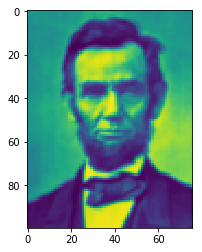

In [11]:
pyplot.imshow(img_1)

In [5]:
#pyplot.imshow(X=img_1, cmap='gray')
#pyplot.imshow(X=img_2)
Y1_norm = np.divide(Y1, np.amax(Y1))

#Training Lincoln Model
Y1_pred = adam(input_data = X1, output_data = Y1_norm, inter_layer_sizes=[128,256], max_iterations=10, minibatch_size=128, learning_rate=0.001)

Cost Function: 0.15817464607008952
Cost Function: 0.12462814923855647
Cost Function: 0.12467490012212222
Cost Function: 0.0863192726109729
Cost Function: 0.10869372717343442
Cost Function: 0.08624423977923498
Cost Function: 0.06550396780069384
Cost Function: 0.08767956500271767
Cost Function: 0.06367818846446174
Cost Function: 0.05977075407311705
Final W: [array([[ 0.67721086, -0.33622633, -0.77526667, -0.94661386,  0.92891785,
        -0.50255709,  0.73905927, -0.7250739 , -0.96560575,  0.84438899,
         0.22645912,  0.20656774,  0.78302779,  0.64577577,  0.11158567,
         0.50074543, -0.25186305,  0.05632023, -0.34161708, -0.29666561,
         0.00230845,  0.73307856, -0.3210097 ,  0.96831552, -0.25979807,
        -0.1083531 , -0.98371996,  0.58868636,  0.67133963, -0.38498688,
        -0.91747662,  0.77008265, -0.77317486,  0.44089265, -0.1824507 ,
        -0.13559093, -0.09033747, -0.5935132 ,  0.3257549 ,  0.97911195,
         0.11490696, -0.8659656 , -0.44149876,  0.8242874

[[0.57740587]
 [0.58577406]
 [0.60251045]
 ...
 [0.21757323]
 [0.19246861]
 [0.17573221]]


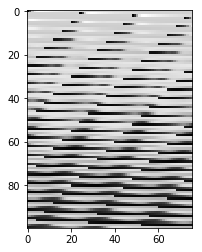

In [6]:
#Showing Lincoln Results
print(Y1_norm)
#print(Y1_pred)
#print(Y1_pred)
pyplot.imshow(X=np.array(Y1_pred).reshape(100,76), cmap='gray')

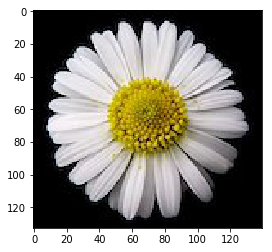

In [9]:
# Flower ogirinal
pyplot.imshow(img_2)

In [7]:
#Training Flower Model
img_2 = Y2.reshape(133, 140, 3)/np.amax(Y2)
Y2_norm = np.divide(Y2, np.amax(Y2))
Y2_pred = adam(input_data=X2, output_data=Y2_norm, inter_layer_sizes=[32,16], max_iterations=100, minibatch_size=1024, learning_rate=0.001)

Cost Function: 0.33059009695025765
Cost Function: 0.32783482373356104
Cost Function: 0.31307668690189283
Cost Function: 0.30795960995105176
Cost Function: 0.29364700856384796
Cost Function: 0.28928957221454926
Cost Function: 0.27092614796794784
Cost Function: 0.2635612733840733
Cost Function: 0.25012927095257886
Cost Function: 0.2447266891697188
Cost Function: 0.23778280170674954
Cost Function: 0.22116598781976507
Cost Function: 0.21921871465431028
Cost Function: 0.22031713268208455
Cost Function: 0.21128240710699694
Cost Function: 0.2126583523250855
Cost Function: 0.20785435743581046
Cost Function: 0.21050190673424332
Cost Function: 0.20816775413202773
Cost Function: 0.20955089227773085
Cost Function: 0.20845270805909244
Cost Function: 0.2114649518394808
Cost Function: 0.21421157970212729
Cost Function: 0.21330880568052382
Cost Function: 0.20966152607049018
Cost Function: 0.21008755535420334
Cost Function: 0.2052141372210291
Cost Function: 0.20951807328296684
Cost Function: 0.20668040

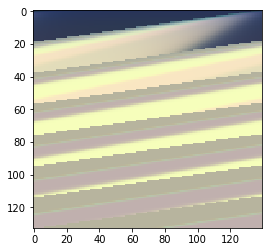

In [8]:
#Showing Flower Results
pyplot.imshow(X=np.array(Y2_pred).reshape(133,140,3)/np.amax(Y2_pred))
pyplot.show()